In [1]:
!pip install hyperopt
!pip install fasttext # necesario para importar los modulos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 5.0 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3163431 sha256=e57a8f3b2d1980ddb363fc0dc4a382ee7d98c56c27a3d772113ea66cf6f18d69
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [2]:
!pip install --upgrade --force lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 33.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 24.8 MB 11.5 MB/s 
     |████████████████████████████████| 15.7 MB 11.8 MB/s 
     |████████████████████████████████| 297 kB 56.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpoolctl-3.1.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uni

**Si te dice de reiniciar el runtime, hacelo**

In [3]:
# Clonamos el repo para usar el codigo de la lib
!git clone https://github.com/elsonidoq/ml-practico-2022.git 

Cloning into 'ml-practico-2022'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 154 (delta 72), reused 119 (delta 41), pack-reused 0
Receiving objects: 100% (154/154), 2.78 MiB | 28.72 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [4]:
import sys
sys.path.append('ml-practico-2022/lib')

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
import pandas as pd
from taller_model_selection.evaluate import load_train_dev_test

(X_train, y_train), (X_dev, y_dev), test = load_train_dev_test('/content/gdrive/MyDrive/taller-model-selection-data')

{'pct(train)': 0.7837289649483001, 'pct(dev)': 0.11952685477518159, 'pct(test)': 0.09674418027651828}


In [7]:
from taller_model_selection.transformers import FeatureProjection
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

features_pipe = make_union(
    make_pipeline(
        FeatureProjection(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']),
        SimpleImputer()
    ),
    make_pipeline(
        FeatureProjection(['l3']), 
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(sparse=False)
    ), 
    make_pipeline(
        FeatureProjection(['l4']), 
        SimpleImputer(strategy='constant'),
        OneHotEncoder(sparse=False)
    ), 
)

In [12]:
import lightgbm as lgb
from pprint import pprint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

from taller_model_selection.evaluate import rmse

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    print(params)
    pipe = make_pipeline(
        features_pipe,
        lgb.LGBMRegressor(random_state=42, **params)
    )
    t0 = time()
    pipe.fit(X_train, y_train)
    train_time = time() - t0
    loss=rmse(y_dev, pipe.predict(X_dev))
    print(f'loss {loss:.02f}')
    return dict(
        loss=loss,
        tr_loss=rmse(y_train, pipe.predict(X_train)), 
        params=params,
        train_time=train_time,
        status=STATUS_OK
    )

In [17]:
import numpy as np

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 300, 10),
    'subsample': hp.quniform('subsample', 0.5, 1.0, 0.1),
    'objective': hp.choice('objective', ["regression", "regression_l1"]),
    'learning_rate': hp.qloguniform('learning_rate', np.log(0.01), np.log(0.3), 0.01),
    'reg_alpha': hp.choice('ra', [0, hp.quniform('reg_alpha', 0.01, 0.1, 0.01)]),
}

trials = Trials()

In [18]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

{'learning_rate': 0.28, 'n_estimators': 20, 'objective': 'regression', 'reg_alpha': 0.02, 'subsample': 0.5}
loss 295388.95
{'learning_rate': 0.23, 'n_estimators': 40, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.8}
loss 335784.66
{'learning_rate': 0.03, 'n_estimators': 230, 'objective': 'regression', 'reg_alpha': 0.1, 'subsample': 1.0}
loss 287989.34
{'learning_rate': 0.01, 'n_estimators': 110, 'objective': 'regression', 'reg_alpha': 0.01, 'subsample': 1.0}
loss 331604.09
{'learning_rate': 0.15, 'n_estimators': 40, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 292266.85
{'learning_rate': 0.22, 'n_estimators': 190, 'objective': 'regression_l1', 'reg_alpha': 0.03, 'subsample': 1.0}
loss 302850.04
{'learning_rate': 0.09, 'n_estimators': 180, 'objective': 'regression_l1', 'reg_alpha': 0.08, 'subsample': 0.9}
loss 312398.83
{'learning_rate': 0.09, 'n_estimators': 10, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 341894.4

In [19]:
def flatten(doc, pref=''):
    res = {}
    for k, v in doc.items():
        k = f'{pref}.{k}' if pref else k
        if isinstance(v, dict):
            res.update(flatten(v, k))
        else:
            res[k] = v
    return res

In [20]:
import pandas as pd
df = pd.DataFrame(list(map(flatten, [e['result'] for e in trials.trials])))
df.sort_values('loss').head()

,loss,tr_loss,params.learning_rate,params.n_estimators,params.objective,params.reg_alpha,params.subsample,train_time,status
10,284600.695318,283454.058813,0.14,190,regression,0.00,0.5,2.664822,ok
12,284865.508132,282882.536586,0.16,170,regression,0.00,0.8,2.610185,ok
19,284957.236786,286156.356323,0.16,140,regression,0.00,0.7,2.592571,ok
13,284975.699779,280018.947499,0.16,200,regression,0.08,0.8,2.658899,ok
18,285684.497075,285171.861806,0.18,130,regression,0.00,0.7,2.277481,ok


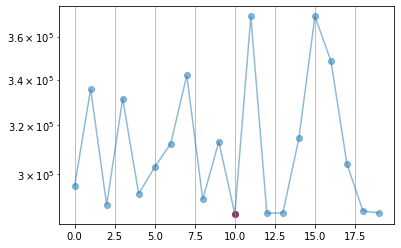

In [23]:
import matplotlib.pyplot as plt

df.loss.plot(style='-o', alpha=0.5)
plt.scatter([df.loss.argmin()], [df.loss.min()], c='r')
# df.tr_loss.plot()
plt.yscale('log')
plt.grid()

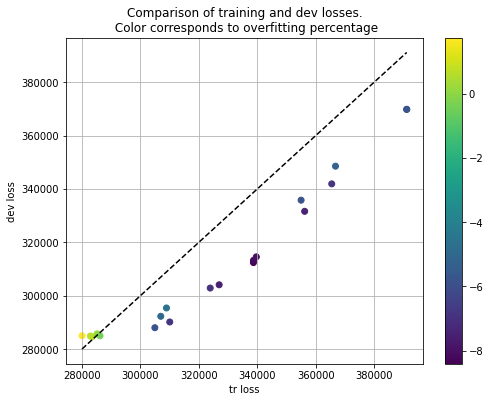

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(df.tr_loss, df.loss, c=(df.loss-df.tr_loss)/df.loss*100)
plt.title('Comparison of training and dev losses.\n Color corresponds to overfitting percentage')
plt.colorbar()
m = min(df.tr_loss.min(), df.loss.min())
M = max(df.tr_loss.max(), df.loss.max())
plt.plot([m, M], [m, M], 'k--')
plt.xlabel('tr loss')
plt.ylabel('dev loss')
plt.grid()

In [65]:
cut_point = df.loss.median()
best_models_df = df[df.loss <= cut_point]
worst_models_df = df[df.loss > cut_point]


def visualize_param(param_name):
  s = df[f'params.{param_name}']
  if s.dtype.name == 'object':
    visualize_categorical_param(param_name)
  else: # assume numerical
    visualize_numerical_param(param_name)

def visualize_categorical_param(param_name):
    pd.concat([
      best_models_df[f'params.{param_name}'].value_counts().rename('best'),
      worst_models_df[f'params.{param_name}'].value_counts().rename('worst')
  ], axis=1).plot.bar()

def visualize_numerical_param(param_name):
  plt.violinplot([
      best_models_df[f'params.{param_name}'],
      worst_models_df[f'params.{param_name}']
  ])
  plt.xticks([1, 2], ['best', 'worst'])

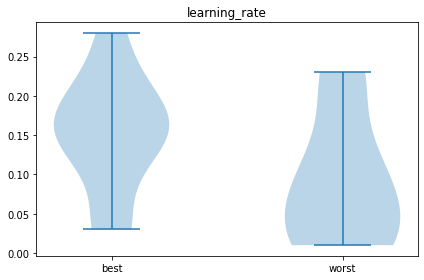

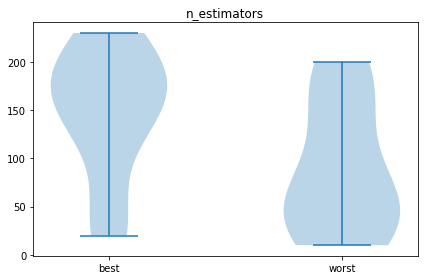

<Figure size 432x288 with 0 Axes>

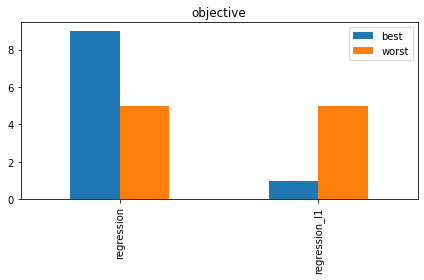

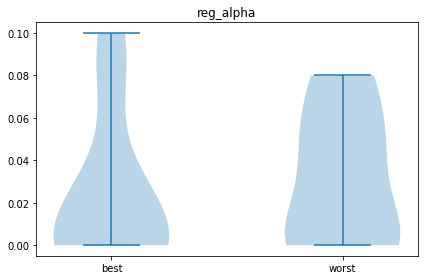

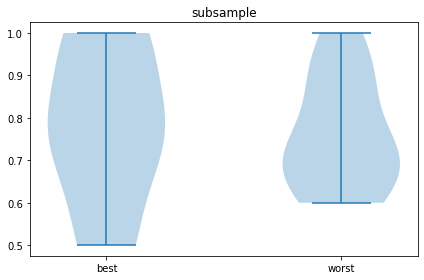

In [66]:
param_names = list(trials.trials[0]['result']['params'].keys())
for param_name in param_names:
  plt.figure()
  visualize_param(param_name)
  plt.title(param_name)
  plt.tight_layout()

# Elegimos el champion y hacemos error analysis

In [67]:
# El que menos overfittea de los mejors
best = df[df.loss < df.loss.min() * 1.001].sort_values('tr_loss', ascending=False).head(30)
best

,loss,tr_loss,params.learning_rate,params.n_estimators,params.objective,params.reg_alpha,params.subsample,train_time,status
10,284600.695318,283454.058813,0.14,190,regression,0.0,0.5,2.664822,ok
12,284865.508132,282882.536586,0.16,170,regression,0.0,0.8,2.610185,ok


In [68]:
params = {k.replace('params.', ''):v for k, v in best.iloc[0].to_dict().items() if 'params.' in k}
rf_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMRegressor(random_state=42, **params)
)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureprojection',
                                                                  FeatureProjection(fields=['rooms',
                                                                                            'bedrooms',
                                                                                            'bathrooms',
                                                                                            'surface_total',
                                                                                            'surface_covered'])),
                                                                 ('simpleimputer',
                                                                  SimpleImputer())])),
                                                ('pipeline-2',
                                                 Pi

In [137]:
# Con el modelo entrenado, generamos predicciones 
# y calculamos el error por cada ejemplo

y_hat_dev = rf_pipe.predict(X_dev)
y_dev = np.asarray(y_dev)
err_dev = y_dev - y_hat_dev
rmse(y_dev, y_hat_dev)

284600.69531774666

In [136]:
best.loss.iloc[0] # validamos que da el mismo error que lo que tuvimos en el model selection

284600.69531774666

(-252673.50437186606, 964)

In [138]:
# Ahora vamos a elegir los ejemplos donde mas le pifiamos por arriba
# O sea, donde el error (true - predicted) es negativo y muy bajo

worst_over_price = np.percentile(err_dev, 5)
over_price_examples = [dict(x=e, y=y_dev[i], y_hat=y_hat_dev[i]) for i, e in enumerate(X_dev) if err_dev[i] < worst_over_price]
worst_over_price, len(over_price_examples)

# Ahora vamos a elegir los ejemplos donde mas le pifiamos por abajo
# O sea, donde el error (true - predicted) es positivo y muy alto
worst_under_price = np.percentile(err_dev, 95)
under_price_examples = [dict(x=e, y=y_dev[i], y_hat=y_hat_dev[i]) for i, e in enumerate(X_dev) if err_dev[i] > worst_under_price]
worst_under_price, len(under_price_examples)

(171503.24813016455, 964)

# Visualizamos los ejemplos con mas error en cada punta

In [131]:
from random import sample
from IPython.display import display_markdown, display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def display_examples(examples, n=3):
  for ex in sample(examples, n):
    display_markdown(f'###{ex["x"]["title"]}', raw=True)
    display(pd.Series(dict(
        true_price=ex['y'], predicted_price=ex['y_hat'],
        absolute_error=abs(ex['y'] - ex['y_hat']), relative_error=abs(ex['y'] - ex['y_hat'])/ex['y'], 
    )))
    display_markdown('###Description', raw=True)
    display_markdown(ex['x']['description'][:300] + ' ...', raw=True)
    display(pd.Series(ex['x']).drop(index=['description', 'title']))


display_markdown("#Under price examples", raw=True)
display_examples(under_price_examples)

display_markdown("#Over price examples", raw=True)
display_examples(over_price_examples)

#Under price examples

###Oficina Boutique en imponente Edificio Corporativo Inteligente

true_price        1200000.000
predicted_price    877960.776
absolute_error     322039.224
relative_error          0.268
dtype: float64

###Description

GRAN OFICINA EN EMBLEMATICO EDIFICIO DE GRAN CATEGORIA E IMAGEN CORPORATIVA EN 9 DE JULIO Y BELGRANO<br><br><br>OFICINA<br>-Oficina en PB  con disposición  cruzada al frente y contrafrente <br>- Son  590 m2 totales  distribuidos en: recepción y hall de espera, cómoda área de trabajo sectorizada,  2  ...

id                 wNkfwUaKLU3WmwOm4P+oLg==
ad_type                           Propiedad
start_date                       2021-03-22
end_date                         2021-06-05
created_on                       2021-03-22
lat                                 -34.613
lon                                 -58.382
l1                                Argentina
l2                          Capital Federal
l3                                Monserrat
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                 4.000
bedrooms                              4.000
bathrooms                             2.000
surface_total                       596.000
surface_covered                     550.000
currency                                USD
price_period                        Mensual
property_type                       Oficina
operation_type                        Venta
dtype: object

###Espectacular vista! Planta renovada

true_price        675000.000
predicted_price   502665.834
absolute_error    172334.166
relative_error         0.255
dtype: float64

###Description

SEMIPISO AL FRENTE EN TORRE AUSTRIA Y LAS HERAS, REFACCIONADO A NUEVO! 4 ambientes 3 suites<br>Espectacular vista al Plaza  y a la biblioteca Nacional. Ubicado a pasos de Av.  Las Heras, exclusiva zona de Recoleta frente a la Biblioteca Nacional. A una cuadra de Av. del Libertador. <br><br>Planta to ...

id                 30aROENDvGQBEygqPUbeYw==
ad_type                           Propiedad
start_date                       2021-03-11
end_date                         2021-06-05
created_on                       2021-03-11
lat                                 -34.584
lon                                 -58.399
l1                                Argentina
l2                          Capital Federal
l3                                 Recoleta
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                 4.000
bedrooms                              3.000
bathrooms                             3.000
surface_total                       162.000
surface_covered                     146.000
currency                                USD
price_period                        Mensual
property_type                  Departamento
operation_type                        Venta
dtype: object

###Lote V. Urquiza excelente 8,66x35,45 const 1.920m 

true_price        840000.000
predicted_price   419587.344
absolute_error    420412.656
relative_error         0.500
dtype: float64

###Description

Corredor Responsable: Mónica Silvia Martinuzzi - CUCICBA 5172Contacto: Diego Fernan Vazquez - MLS ID # 420621063-98Lote V. Urquiza excelente 8,66x35,45 const 1.775mAceptan metros construídos o a construir. Muy buena zona, en expanción. Prefactibilidad adjunta: Altura: 22.80mts  \n\n Comprá la casa q ...

id                 eJSB9NCNzrJqVIAZeuY3Kw==
ad_type                           Propiedad
start_date                       2021-03-05
end_date                         2021-03-07
created_on                       2021-03-05
lat                                 -34.582
lon                                 -58.491
l1                                Argentina
l2                          Capital Federal
l3                            Villa Urquiza
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                   NaN
bedrooms                                NaN
bathrooms                               NaN
surface_total                       307.000
surface_covered                     307.000
currency                                USD
price_period                            NaN
property_type                          Lote
operation_type                        Venta
dtype: object

#Over price examples

###Excelente Piso de Categoría - Recoleta

true_price         980000.000
predicted_price   1652996.221
absolute_error     672996.221
relative_error          0.687
dtype: float64

###Description

Edificio clàsico de 65 años y excelente categorìa en Pza San Martìn ,  zona Cancillerìa, planta de 370 m2,  en plano invertido, donde ambas vistas,  frente y  contrafrente son espectaculares. Al frente, los 3 dormitorios de muy buenos tamaños, el principal una master suite con vestidor , miran al "P ...

id                 CTqF6cGhnPKsVDPAoVKZyw==
ad_type                           Propiedad
start_date                       2021-03-29
end_date                         2021-04-15
created_on                       2021-03-29
lat                                 -34.593
lon                                 -58.378
l1                                Argentina
l2                          Capital Federal
l3                                 Recoleta
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                 6.000
bedrooms                              3.000
bathrooms                             3.000
surface_total                       372.000
surface_covered                     372.000
currency                                USD
price_period                        Mensual
property_type                  Departamento
operation_type                        Venta
dtype: object

###Cochera en Venta en Belgrano, Capital federal U$S 27000

true_price         27000.000
predicted_price   297658.248
absolute_error    270658.248
relative_error        10.024
dtype: float64

###Description

Venta de Cochera  en Belgrano
 XINTEL(LUI-LUI-10770) ...

id                 uPWbFf5rd+I+y4dhaWoROA==
ad_type                           Propiedad
start_date                       2021-04-15
end_date                         2021-04-15
created_on                       2021-04-15
lat                                 -34.566
lon                                 -58.451
l1                                Argentina
l2                          Capital Federal
l3                                 Belgrano
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                 1.000
bedrooms                                NaN
bathrooms                               NaN
surface_total                           NaN
surface_covered                         NaN
currency                                USD
price_period                        Mensual
property_type                       Cochera
operation_type                        Venta
dtype: object

###Cochera en Venta en Belgrano, Capital federal U$S 21500

true_price         21500.000
predicted_price   297658.248
absolute_error    276158.248
relative_error        12.845
dtype: float64

###Description

 Excelente cochera fija muy amplia y comoda ubicada en 1º piso en edificio de cocheras en inmejorable ubicacion.
 XINTEL(LUI-LUI-10482) ...

id                 f6mJGfwnpiJSGgO7rHw+Iw==
ad_type                           Propiedad
start_date                       2021-04-14
end_date                         2021-04-14
created_on                       2021-04-14
lat                                 -34.560
lon                                 -58.453
l1                                Argentina
l2                          Capital Federal
l3                                 Belgrano
l4                                      NaN
l5                                      NaN
l6                                      NaN
rooms                                 1.000
bedrooms                                NaN
bathrooms                               NaN
surface_total                           NaN
surface_covered                         NaN
currency                                USD
price_period                        Mensual
property_type                       Cochera
operation_type                        Venta
dtype: object

In [132]:
X_test, y_test = test

In [133]:
best_model_performance = dict(
    tr_loss=rmse(y_train, rf_pipe.predict(X_train)), 
    dev_loss=rmse(y_dev, rf_pipe.predict(X_dev)),
    test_loss=rmse(y_test, rf_pipe.predict(X_test)), 
)
best_model_performance

{'tr_loss': 283454.05881349073,
 'dev_loss': 284600.69531774666,
 'test_loss': 236769.44746213703}